In [1]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker_original
from tqdm import tqdm
import os 
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import torchattacks as ta
from torchvision import models, transforms
import pandas as pd
from torch import nn
from adversarial_examples_pytorch.adv_gan import target_models
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from types import MethodType
import adversarial_examples_pytorch.adv_gan.generators as generators 
from MNIST.example import Model_C, MnistNet
from gtsrb_pytorch.model import Net as TrafficNET


def load_attack_fun(attack_type,attack_dict):

    system = torch.load(attack_dict['system_ckpt'])
    system.cuda()
    system.eval()

    if attack_type=='vm':
        def vm_attack(img):
            view,unnormalized_view = system.view(img,True)
            return unnormalized_view

        attack_fun = vm_attack

    elif attack_type=='advgan':
        # ### advGAN inference
        thresh=attack_dict['thresh']
        # load corresponding generator
        G = getattr(generators, f'Generator_{attack_dict["dataset_name"].upper()}')()
        checkpoint_name_G = '%s_untargeted.pth.tar'%(attack_dict['threat_model_name'].replace("_80%",""))
        if "80%" in attack_dict['threat_model_name']:
            base = '/workspace/adversarial_examples_pytorch/adv_gan_80_to_20/'
        else:
            base = '/workspace/adversarial_examples_pytorch/adv_gan/'

        checkpoint_path_G = os.path.join(base,'saved', 'generators', f'bound_{thresh}', checkpoint_name_G)
        checkpoint_G = torch.load(checkpoint_path_G, map_location='cpu')
        G.load_state_dict(checkpoint_G['state_dict'])
        G.eval().cuda()

        def advgan_attack(x):
            pert = G(x).data.clamp(min=-thresh, max=thresh)
            x_adv = x + pert
            x_adv = x_adv.clamp(min=0, max=1)
            # views1 = system.normalize(x_adv)
            return x_adv
        
        attack_fun = advgan_attack



    elif attack_type=='fgsm':
        atk = ta.FGSM(attack_dict['threat_model'], eps=attack_dict['thresh'])
        # atk = ta.PGD(threat_model, eps=0.035, alpha=0.035/8, steps=10)
        atk.set_normalization_used(system.dataset.MEAN,system.dataset.STD) # ok to use this system because we also unnormalize results in the end

        def fgsm_attack(img):
            return system.unnormalize(atk(system.normalize(img),labels))
            # return atk(img,labels)

        attack_fun = fgsm_attack

    
    return attack_fun # , system


def load_model(dataset,model_type,model_path):
    if dataset == 'traffic':
        if model_type == 'resnet50':
            model = models.resnet50(pretrained = True)
            IN_FEATURES = model.fc.in_features 
            OUTPUT_DIM = 43
            fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
            model.fc = fc
            threat_model  = model
        elif 'stncnn' == model_type:    
            threat_model  = TrafficNET()
            threat_model.forward = threat_model.forward_original
        elif 'stncnn_80%' == model_type:    
            threat_model  = TrafficNET()
            classes_to_mask = [23,36,24,17,4,31,42,10]
            threat_model.fc2 = nn.Linear(350, 43-len(classes_to_mask))
            threat_model.forward = threat_model.forward_original

    elif dataset == 'birds':

        OUTPUT_DIM = 200

        if 'resnet18' == model_type:
            model = models.resnet18(pretrained = True)
        if 'resnet18_80%' == model_type:
            model = models.resnet18(pretrained = True)
            OUTPUT_DIM = 200-40

        elif model_type == 'resnet50':
            model = models.resnet50(pretrained = True)
        elif model_type == 'resnet50w':
            model = models.wide_resnet50_2(pretrained = True)

        IN_FEATURES = model.fc.in_features 
        fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
        model.fc = fc
        threat_model  = model

    elif dataset == 'mnist':

        if model_type in ['Model_A','Model_B']:
            threat_model = getattr(target_models, model_type)(1, 10)
            checkpoint_f = torch.load(model_path, map_location='cpu')
            threat_model.load_state_dict(checkpoint_f["state_dict"])
            return threat_model.eval().cuda()
        
        elif model_type in ['Model_C']:
            threat_model = getattr(target_models, model_type)(1, 10)
        
        elif model_type == 'Model_C_80%':
            threat_model = getattr(target_models, model_type.replace("_80%",""))(1, 8)
        
        elif model_type == 'resnet18':
            threat_model = models.resnet18(pretrained=False)
            threat_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
            num_ftrs = threat_model.fc.in_features
            threat_model.fc = nn.Linear(num_ftrs, 10)
        
    elif dataset == 'cifar10':
        if model_type == 'resnet34':
            model = models.resnet34(pretrained = True)
        elif model_type == 'resnet50w':
            model = models.wide_resnet50_2(pretrained = True)

        IN_FEATURES = model.fc.in_features 
        OUTPUT_DIM = 10

        fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
        model.fc = fc
        threat_model  = model
        checkpoint_f = torch.load(model_path, map_location='cpu')
        threat_model.load_state_dict(checkpoint_f["state_dict"])
        return threat_model.eval().cuda()

    threat_model.load_state_dict(torch.load(model_path))
    return threat_model.eval().cuda()


In [6]:

mnist_paths ={
    "Model_A": '/workspace/adversarial_examples_pytorch/adv_gan/saved/target_models/best_Model_A_mnist.pth.tar',
    "Model_B": '/workspace/adversarial_examples_pytorch/adv_gan/saved/target_models/best_Model_B_mnist.pth.tar',
    "Model_C": '/workspace/MNIST/model_c_not_normalized.pt',
    "Model_C_80%": '/workspace/MNIST/model_c_not_normalized_8_cls.pt',
    "Model_C_defended": '/workspace/MNIST/model_c_not_normalized_defended.pt',
    "resnet18": '/workspace/MNIST/mnist_res18.pt',
}

mnist_config={
    'dataset' : 'mnist',
    'system_for_dataset':'/workspace/dabs/exp/models/mnist_sweep_2023-01-21_06:32:36/model.ckpt',
    # 'system_for_dataset':'/workspace/dabs/exp/models/mnist_80%_2023-01-22_12:05:47/model.ckpt',
    'threat_model_name': 'Model_C',
    'threat_model_path': mnist_paths['Model_C'],
    'attack':'vm',
    # 'attack':'advgan',
    # 'attack':'fgsm',
    'attack_config':{
        'dataset_name': 'mnist',
        'system_ckpt':'/workspace/dabs/exp/models/mnist_sweep_2023-01-21_06:32:36/model.ckpt',
        'num_views': 10,
        'threat_model_name': 'Model_C',
        'thresh':0.3,
        'threat_model_path': mnist_paths['Model_C'],
    }
}

traffic_paths ={
    "stncnn": '/workspace/gtsrb_pytorch/model/model_40.pth',
    "stncnn_80%": '/workspace/gtsrb_pytorch/gtsrb_stn_80.pth',
    "stncnn_defended": '/workspace/gtsrb_pytorch/model_defended.pth',
    "resnet50": '/workspace/gtsrb_pytorch/gtsrb_resnet50.pth',
}


traffic_config={
    'dataset' : 'traffic',
    'system_for_dataset':'/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt',
    # 'system_for_dataset':'/workspace/dabs/exp/models/traffic_80_budget=0.005_2023-01-25_10:50:22/model.ckpt',
    'threat_model_name': 'stncnn',
    'threat_model_path': traffic_paths['stncnn'],
    'attack':'vm',
    # 'attack':'advgan',
    # 'attack':'fgsm',
    'attack_config':{
        'dataset_name': 'traffic',
        'system_ckpt':'/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt',
        # 'system_ckpt':'/workspace/dabs/exp/models/traffic_80_budget=0.005_2023-01-25_10:50:22/model.ckpt',
        'num_views': 5,
        'threat_model_name': 'stncnn',
        'thresh':0.005,
        'threat_model_path': traffic_paths['stncnn'],
    }
}

birds_paths ={
    "resnet18": '/workspace/cubirds/resnet18-224.pt',
    "resnet18_80%": '/workspace/cubirds/resnet18-80p.pt',
    "resnet18_defended": '/workspace/cubirds/resnet18-adv.pt',
    "resnet50": '/workspace/cubirds/test.pt', # ?
    "resnet50w": '/workspace/cubirds/wres50.pt',
}


birds_config={
    'dataset' : 'birds',
    'system_for_dataset':'/workspace/dabs/exp/models/birds_dyn_sweep_budget=0.025/model.ckpt',
    # 'system_for_dataset':'/workspace/dabs/exp/models/birds_80_budget=0.025_2023-01-25_15:25:43/model.ckpt',
    'threat_model_name': 'resnet18',
    'threat_model_path': birds_paths['resnet18'],
    'attack':'vm',
    # 'attack':'advgan',
    # 'attack':'fgsm',
    'attack_config':{
        'dataset_name': 'birds',
        'system_ckpt':'/workspace/dabs/exp/models/birds_dyn_sweep_budget=0.025/model.ckpt',
        # 'system_ckpt':'/workspace/dabs/exp/models/birds_80_budget=0.025_2023-01-25_15:25:43/model.ckpt',
        'num_views': 3,
        'threat_model_name': 'resnet18',
        'thresh':0.025,
        'threat_model_path': birds_paths['resnet18'],
    }
    
}



cifar_paths ={
    "resnet34": '/workspace/adversarial_examples_pytorch/adv_gan/saved/target_models/best_resnet34_cifar10.pth.tar',
    "resnet50w": '/workspace/adversarial_examples_pytorch/adv_gan/saved/target_models/best_resnet50w_cifar10.pth.tar',
}

cifar_config={
    'dataset' : 'cifar10',
    'system_for_dataset':'/workspace/dabs/exp/models/cifar_dyn_2023-01-29_09:38:19/model.ckpt',
    'threat_model_name': 'resnet34',
    'threat_model_path': cifar_paths['resnet34'],
    # 'attack':'vm',
    'attack':'advgan',
    # 'attack':'fgsm',
    'attack_config':{
        'dataset_name': 'cifar10',
        'system_ckpt':'/workspace/dabs/exp/models/cifar_dyn_2023-01-29_09:38:19/model.ckpt',
        'num_views': 3,
        'threat_model_name': 'resnet34',
        'thresh':0.03,
        'threat_model_path': cifar_paths['resnet34'],
    }
}


In [23]:
# run_config = birds_config
run_config = cifar_config
# run_config = mnist_config
# run_config = traffic_config


#load datasets
system = torch.load(run_config['system_for_dataset'])
loaders = [system.train_dataloader(), system.val_dataloader()]

threat_model = load_model(run_config['dataset'],run_config['threat_model_name'],run_config['threat_model_path'])

if run_config['attack'] == 'fgsm':
    run_config['attack_config']['threat_model'] = load_model(run_config['dataset'],run_config['attack_config']['threat_model_name'],run_config['attack_config']['threat_model_path'])

attack_fun = load_attack_fun(run_config['attack'],run_config['attack_config']) # gets unnormalize image, return unnormalize adversarial image


In [24]:


pl.seed_everything(123654)


df_dict = {
    "label" : [],
    "pred" : [],
    "adv_pred": []
}


stop = False
augs = []
for loader in loaders:
    for index , img , labels in tqdm(loader):
        # with torch.no_grad():
        img = img.cuda()
        for i in range(run_config['attack_config']['num_views']):
            adv_img = attack_fun(img) # unnormalized in , unnormalized out
            augs.append(adv_img)
            pred = threat_model(system.normalize(img)).argmax(1, keepdim = True)
            adv_pred = threat_model(system.normalize(adv_img)).argmax(1, keepdim = True)

            df_dict['label'].append(labels.unsqueeze(-1).cpu())
            df_dict['pred'].append(pred.cpu())
            df_dict['adv_pred'].append(adv_pred.cpu())
            
        stop = True
        if stop:
            break
    if stop:
        break

      


Global seed set to 123654
  0%|          | 0/390 [00:00<?, ?it/s]


6 tensor(4) tensor([4], device='cuda:0') tensor([4], device='cuda:0')


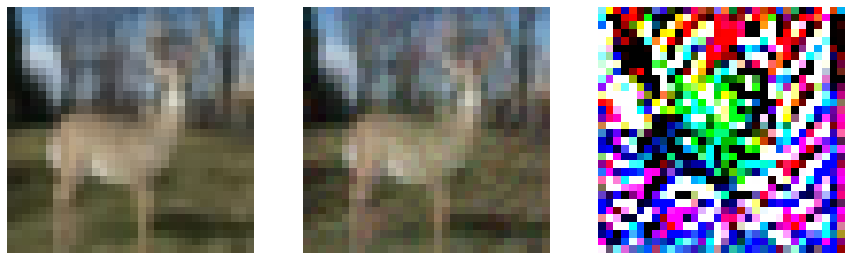

In [28]:
i +=1
print(i, labels[i], pred[i], adv_pred[i])
w = 15
fig, ax = plt.subplots(1,3,figsize=(w,w*3))
plot_row(img,adv_img,i,ax)
fig.show()

In [10]:
def heatmap_of_view_effect(original,view):
    diff = view-original
    diff_offset = (diff.flatten(start_dim=1)-diff.flatten(start_dim=1).min(-1)[0].unsqueeze(-1)).view(diff.shape)
    diff_heatmap = (diff_offset.flatten(start_dim=1)/diff_offset.flatten(start_dim=1).max(-1)[0].unsqueeze(-1)).view(diff_offset.shape)
    return diff_heatmap

def plot_row(img,adv_img,i,ax):
    if img.shape[1] == 1:
        ax[0].imshow(img[i].detach().cpu()[0],cmap='gray')
        ax[1].imshow(adv_img[i].detach().cpu()[0],cmap='gray')
        ax[2].imshow((adv_img[i]-img[i]).detach().cpu()[0],cmap='gray')
    if img.shape[1] == 3:
        ax[0].imshow(img[i].detach().cpu().permute(1,2,0))
        ax[1].imshow(adv_img[i].detach().cpu().permute(1,2,0))
        ax[2].imshow(heatmap_of_view_effect(img[i],adv_img[i]).detach().cpu().permute(1,2,0))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

def plot_all_augs(img,augs,i,ax):
    if img.shape[1] == 1:
        ax[0].imshow(img[i].detach().cpu()[0],cmap='gray')
        for k,aug in enumerate(augs):
            ax[k+1].imshow(augs[k][i].detach().cpu()[0],cmap='gray')
        # ax[2].imshow((adv_img[i]-img[i]).detach().cpu()[0],cmap='gray')
    if img.shape[1] == 3:
        ax[0].imshow(img[i].detach().cpu().permute(1,2,0))
        for k,aug in enumerate(augs):
            ax[k+1].imshow(augs[k][i].detach().cpu().permute(1,2,0))
        # ax[2].imshow(heatmap_of_view_effect(img[i],adv_img[i]).detach().cpu().permute(1,2,0))
    for k in range(len(ax)):
        ax[k].axis('off')


In [ ]:
uni = np.unique(labels)
r = len(uni)
w = 5
c = (run_config['attack_config']['num_views']) + 1
fig, ax = plt.subplots(r,c,figsize=(c*w,w*r))

for j in range(r):
    i = labels.tolist().index(uni[j])
# for j,i in enumerate([59,65,92]):
    # plot_row(img,adv_img,i,ax[j])
    plot_all_augs(img,augs,i,ax[j])
fig.show()

In [ ]:

df_dict['label'] = torch.vstack(df_dict['label']).squeeze().numpy()
df_dict['pred'] = torch.vstack(df_dict['pred']).squeeze().numpy()
df_dict['adv_pred'] = torch.vstack(df_dict['adv_pred']).squeeze().numpy()

df = pd.DataFrame.from_dict(df_dict)

consistency_acc = (df['pred'] == df['adv_pred']).mean()
adv_acc = (df['label'] == df['adv_pred']).mean()
acc = (df['pred'] == df['label']).mean()

print(f'Original Acc={100*acc:.2f}% , Adv Acc={100*adv_acc:.2f}% (ASR={100*(1-adv_acc):.2f}) , Consistency Acc={100*consistency_acc:.2f}(ASR={100*(1-consistency_acc):.2f})')
print(run_config)



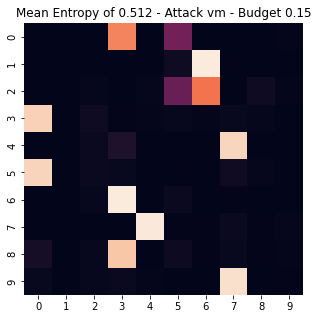

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy



cf_matrix = confusion_matrix(df['pred'], df['adv_pred'], normalize='true')
H = entropy(cf_matrix, base=len(cf_matrix))


plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix,cbar=False)
plt.title(f'Mean Entropy of {H.mean():.3f} - Attack {run_config["attack"]} - Budget {run_config["attack_config"]["thresh"]}')
plt.show()

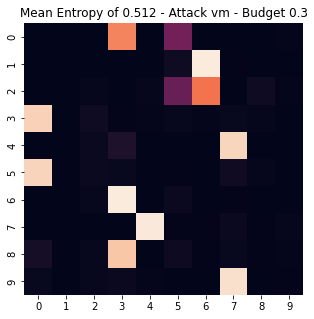

In [59]:
cf_matrix = confusion_matrix(df['pred'], df['adv_pred'], normalize='true')
H = entropy(cf_matrix, base=len(cf_matrix))


plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix,cbar=False)
plt.title(f'Mean Entropy of {H.mean():.3f} - Attack {run_config["attack"]} - Budget {run_config["attack_config"]["thresh"]}')
plt.show()